# Machine Learning

In [1]:
from cider.datastore import DataStore
from cider.ml import Learner
import sys
import os

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Initialize data store object, then learner, automatically loading feature file produced by featurizer, along with file of data labels, and merging features to labels.

In [2]:
# This path should point to your cider installation, where configs and data for this demo are located.
from pathlib import Path
cider_installation_directory = Path('../../cider')

In [5]:
import pandas as pd
features_non_anonymized = pd.read_csv(cider_installation_directory / 'synthetic_data' / 'features.csv')
labels_non_anonymized = pd.read_csv(cider_installation_directory / 'synthetic_data' / 'labels.csv')

features_anonymized = pd.read_csv(cider_installation_directory / 'walkthrough_outputs' / 'featurizer' / 'datasets' / 'features.csv')
labels_anonymized = pd.read_csv(cider_installation_directory / 'walkthrough_outputs' / 'anonymized' / 'outputs'/ 'labels.csv')

In [22]:
datastore = DataStore(config_file_path_string = cider_installation_directory / 'configs' / 'colab_walkthrough' / 'config_post_anonymizing.yml')

In [23]:
learner = Learner(datastore=datastore, clean_folders=True)#, dataframes={'features': features_non_anonymized, 'labels': labels_non_anonymized})

Number of observations with features: 981 (981 unique)
Number of observations with labels: 50 (50 unique)
Number of matched observations: 50 (50 unique)


Experiment quickly with untuned models to get a sense of accuracy. Lasso, Ridge, random forest, and gradient boosting models are implemented natively, other models can be implemented by hand.

In [6]:
lasso_scores = learner.untuned_model('lasso')
randomforest_scores = learner.untuned_model('randomforest')
print('LASSO', lasso_scores)
print('Random Forest', randomforest_scores)

/Users/leo/miniconda3/envs/cider3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e+04, tolerance: 1.946e+04
  model = cd_fast.enet_coordinate_descent(


LASSO {'train_r2': '1.00 (0.00)', 'test_r2': '0.67 (0.15)', 'train_rmse': '40.91 (40.55)', 'test_rmse': '1095.88 (151.20)'}
Random Forest {'train_r2': '0.96 (0.01)', 'test_r2': '0.66 (0.09)', 'train_rmse': '435.47 (11.42)', 'test_rmse': '1148.97 (98.58)'}


Fine-tune a gradient boosting model, tuning hyperparameters over cross validation, and produce predictions for all labeled observations out-of-sample over cross-validation. Also generate predictions for all subscribers in the feature dataset. 

In [19]:
gradientboosting_scores = learner.tuned_model('gradientboosting')
print('Gradient Boosting (Tuned)', gradientboosting_scores)
learner.oos_predictions('gradientboosting', kind='tuned')
learner.population_predictions('gradientboosting', kind='tuned')

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Gradient Boosting (Tuned) {'train_r2': '0.96 (0.02)', 'test_r2': '0.57 (0.11)', 'train_rmse': '378.50 (113.09)', 'test_rmse': '1358.42 (149.07)'}
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


,name,predicted
0,1068395,20630.058767
1,1088875,21271.538442
2,1151815,17749.106573
3,1155381,21934.390442
4,1159103,17590.114261
...,...,...
76,9872262,18273.036568
77,9875304,19888.961595
78,9889775,18895.698685
79,9891565,22347.602208


In [20]:
unanon_merge = datastore.merged.sort_values('label')

Evaluate the model’s accuracy. Produce a scatterplot of true vs. predicted values with a LOESS fit and a bar plot of the most important features. Generate a table showing the targeting accuracy, precision, and recall of the predictions for nine hypothetical targeting scenarios (targeting between 10% and 90% of the population). 

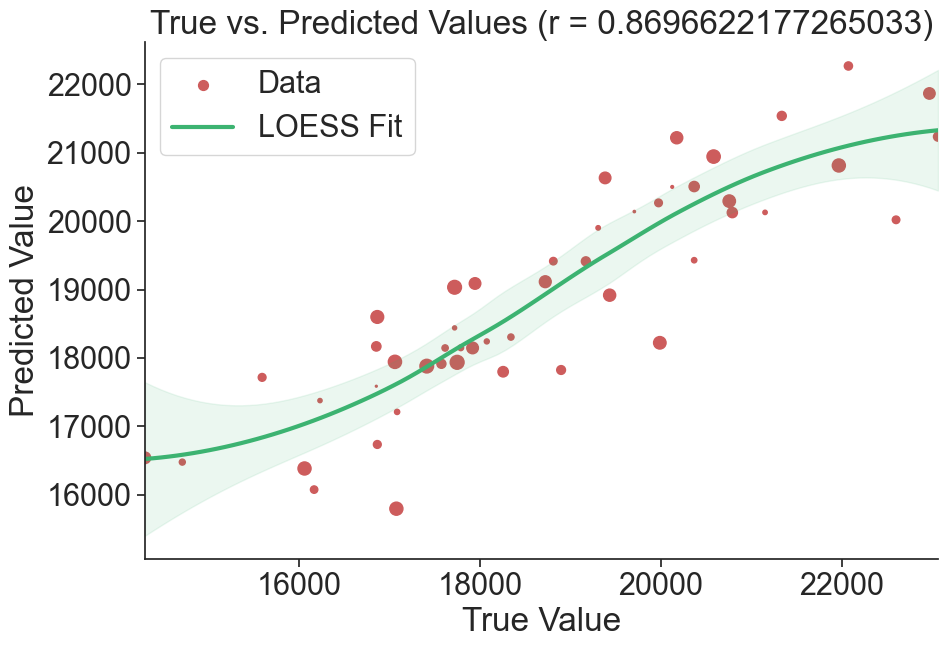

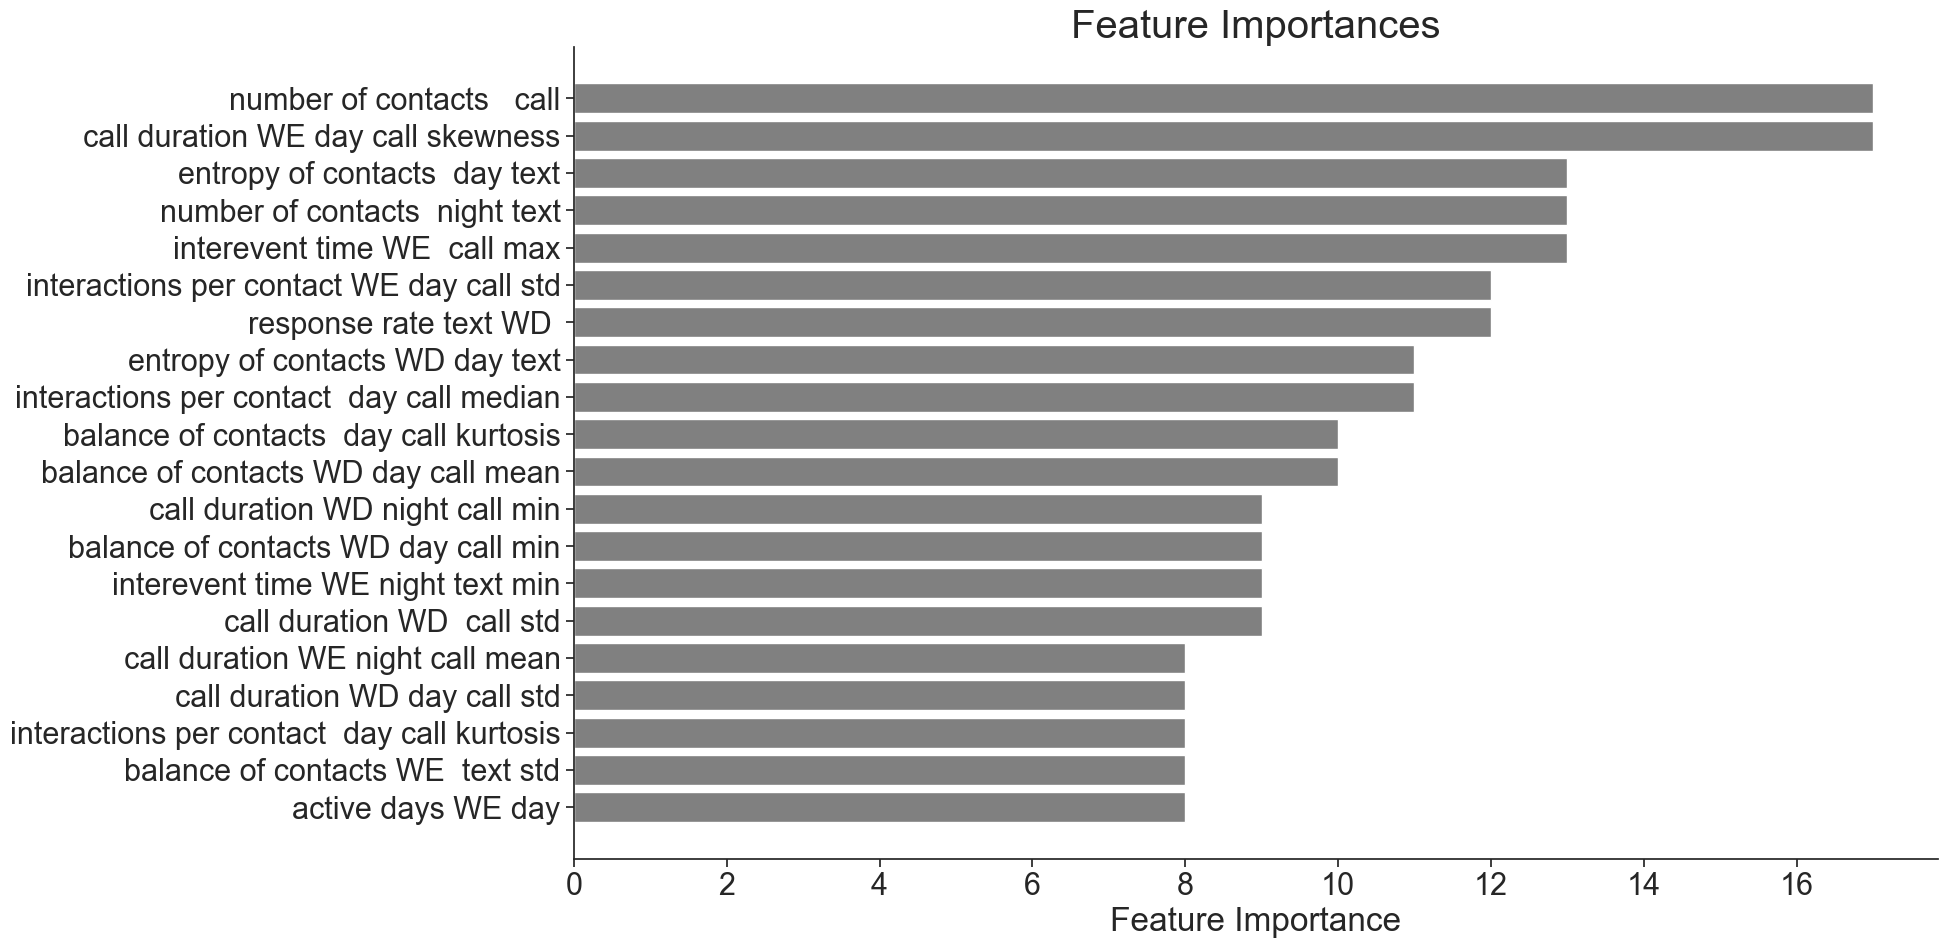

,Proportion of Population Targeted,Pearson,Spearman,AUC,Accuracy,Precision,Recall
0,10%,0.87,0.85,0.85,92%,61%,61%
1,20%,0.87,0.85,0.85,83%,59%,59%
2,30%,0.87,0.85,0.85,81%,68%,68%
3,40%,0.87,0.85,0.85,82%,77%,77%
4,50%,0.87,0.85,0.85,85%,85%,85%
5,60%,0.87,0.85,0.85,86%,88%,88%
6,70%,0.87,0.85,0.85,91%,93%,93%
7,80%,0.87,0.85,0.85,85%,90%,90%
8,90%,0.87,0.85,0.85,92%,95%,95%


In [15]:
learner.scatter_plot('gradientboosting', kind='tuned')
learner.feature_importances_plot('gradientboosting', kind='tuned')
learner.targeting_table('gradientboosting', kind='tuned')

In [29]:
learner = Learner(datastore=datastore, clean_folders=True, dataframes={'features': features_anonymized, 'labels': labels_anonymized})

/Users/leo/miniconda3/envs/cider3.9/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/leo/miniconda3/envs/cider3.9/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Number of observations with features: 981 (981 unique)
Number of observations with labels: 50 (50 unique)


Number of matched observations: 50 (50 unique)


In [24]:
anon_merge = datastore.merged.sort_values('label')

In [16]:
gradientboosting_scores = learner.tuned_model('gradientboosting')
print('Gradient Boosting (Tuned)', gradientboosting_scores)
learner.oos_predictions('gradientboosting', kind='tuned')
learner.population_predictions('gradientboosting', kind='tuned')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Gradient Boosting (Tuned) {'train_r2': '0.98 (0.02)', 'test_r2': '0.50 (0.10)', 'train_rmse': '280.51 (140.16)', 'test_rmse': '1414.91 (219.60)'}
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


,name,predicted
0,076YPy0ALjpzJpN3,21961.194196
1,076YPy0K53vQJpN3,21718.169557
2,076YPy0LjppyJpN3,20990.453914
3,076YPy0N9BWDJpN3,19064.455491
4,076YPy0aZ3LzJpN3,20383.635954
...,...,...
76,xP32z6ANLkvyLdop,18241.747473
77,xP32z6APY4vyLdop,17875.210819
78,xP32z6AvBYGyLdop,22283.858228
79,xP32z6WKkNYDLdop,19954.547851


In [25]:
anon_merge.reset_index(drop=True, inplace=True)
unanon_merge.reset_index(drop=True, inplace=True)

In [26]:
for c in anon_merge.columns:
    num_same = (
            ((anon_merge[c] == unanon_merge[c]))
            | (anon_merge[c].isna() & unanon_merge[c].isna())
        ).sum()
    if num_same == 50:
        continue
    try:
        max_diff = ((anon_merge[c] - unanon_merge[c]).max())
        if max_diff < 10e-4:
            continue
    except:
        print(c, num_same, 'cant subtract')
        continue
    print(c, num_same, max_diff)

name 0 cant subtract
percent_at_home_allweek_allday 42 0.0131578947368421
percent_at_home_allweek_day 42 0.0235294117647058
percent_at_home_weekday_allday 35 0.024999999999999998
percent_at_home_weekday_day 44 0.0169491525423728
percent_at_home_weekday_night 31 0.0357142857142857
percent_at_home_weekend_allday 30 0.0465116279069767
percent_at_home_weekend_day 47 0.0434782608695652
percent_at_home_weekend_night 31 0.0714285714285714
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will b